In [1]:
import random
import torch
import numpy as np
from torch.utils import data

In [2]:
data_train = torch.from_numpy(np.loadtxt('two_spiral_train_data.txt')).float()
data_test = torch.from_numpy(np.loadtxt('two_spiral_test_data.txt')).float()

In [3]:
def load_data(data_ori, batch_size, is_train = True):
    data_in = data_ori[:, 0:2]
    data_out = data_ori[:, 2]
    return data.DataLoader(data.TensorDataset(data_in, data_out), batch_size, shuffle = is_train)

In [4]:
batch_size = 30
data_train_iter = load_data(data_train, batch_size, True)
data_test_iter = load_data(data_test, batch_size, False)

In [5]:
input_num = 2
hidden_num = 512
output_num = 2

u1 = torch.normal(0, 0.01, size = (input_num, hidden_num), requires_grad = True)
v1 = torch.normal(0, 0.01, size = (input_num, hidden_num), requires_grad = True)
b1 = torch.zeros(hidden_num, requires_grad=True)

u2 = torch.normal(0, 0.01, size = (hidden_num, output_num), requires_grad = True)
v2 = torch.normal(0, 0.01, size = (hidden_num, output_num), requires_grad = True)
b2 = torch.zeros(output_num, requires_grad=True)

# parameters with highest accuracy rate
u1_max = torch.normal(0, 0.01, size = (input_num, hidden_num), requires_grad = True)
v1_max = torch.normal(0, 0.01, size = (input_num, hidden_num), requires_grad = True)
b1_max = torch.zeros(hidden_num, requires_grad=True)

u2_max = torch.normal(0, 0.01, size = (hidden_num, output_num), requires_grad = True)
v2_max = torch.normal(0, 0.01, size = (hidden_num, output_num), requires_grad = True)
b2_max = torch.zeros(output_num, requires_grad=True)

#print(u1, v1, b1, u2, v2, b2)

def quadratic_layer(u, v, b, x):
    return torch.matmul(x**2, u) + torch.matmul(x, v) + b

def sigmoid(x):
    x_exp = torch.exp(-x)
    return 1 / (1 + x_exp)

def softmax(x):
    x_max = torch.max(x)
    x_exp = torch.exp(x - x_max)
    partition = x_exp.sum(1, keepdim=True)
    return x_exp / partition

def mlqp(x, u1, v1, b1, u2, v2, b2):
    out1 = sigmoid(quadratic_layer(u1, v1, b1, x))
    out2 = quadratic_layer(u2, v2, b2, out1)
    return softmax(out2)

def cross_entropy(y_hat, y):
    return -1 * torch.log(y_hat[range(len(y_hat)), y])

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            #print(param.grad)
            param -= lr * param.grad / batch_size
            param.grad.zero_()


#net = nn.Sequential(nn.Linear(input_num, hidden_num), nn.Sigmoid(), nn.Linear(hidden_num, output_num), nn.Sigmoid())

#def weight_init(layer):
#    if type(layer) == nn.Linear:
#        nn.init.normal_(layer.weight, std = 1)
        
#net.apply(weight_init)
#net = net.float()
#for parameter in net.parameters():
#    print(parameter)

In [6]:
lr = 0.1
epoch_num = 1000
#loss = nn.CrossEntropyLoss(reduction='none')
#updater = torch.optim.SGD(net.parameters(), lr=lr)

net = mlqp
loss = cross_entropy
updater = sgd

def accuracy(y_hat, y):
    y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train_spiral(net, train_iter, loss, updater, epoch_num, lr, batch_size):
    accuracy_max = 0
    for i in range(epoch_num):
        accuracy_rate = [0., 0., 0.] # loss, predict right, num
        for x, y in train_iter:
            y_hat = net(x, u1, v1, b1, u2, v2, b2)
            #print(y.long())
            l = loss(y_hat, y.long())
            #print(l)
            #updater.zero_grad()
            l.sum().backward()
            #updater.step()
            updater([u1, v1, b1, u2, v2, b2], lr, batch_size)
            accuracy_rate[0] = accuracy_rate[0] + l.sum()
            accuracy_rate[1] = accuracy_rate[1] + accuracy(y_hat, y)
            accuracy_rate[2] = accuracy_rate[2] + y.numel()
        accuracy_now = accuracy_rate[1] / accuracy_rate[2]
        if accuracy_now > accuracy_max:
            accuracy_max = accuracy_now
            print('max accuracy:', accuracy_max)
            u1_max, v1_max, b1_max, u2_max, v2_max, b2_max = u1 * 1, v1 * 1, b1 * 1, u2 * 1, v2 * 1, b2 * 1
        print('loss: {0}, accuracy: {1}'.format(accuracy_rate[0] / accuracy_rate[2], accuracy_rate[1] / accuracy_rate[2]))
        
import matplotlib.pyplot as plt
        
def plot_decision_boundary(x, y_hat, color = ['b', 'r']):
    y_hat = y_hat.argmax(axis=1)
    col = []
    for i in range(0, len(y_hat)):
        col.append(color[y_hat[i]])
    plt.scatter(x[:, 0], x[:, 1], c = col)
    
def evaluate_spiral(net, test_iter, u1_g, v1_g, b1_g, u2_g, v2_g, b2_g):
    accuracy_rate = [0., 0.]
    with torch.no_grad():
        for x, y in test_iter:
            y_hat = net(x, u1_g, v1_g, b1_g, u2_g, v2_g, b2_g)
            plot_decision_boundary(x, y_hat)
            accuracy_rate[0] = accuracy_rate[0] + accuracy(y_hat, y)
            accuracy_rate[1] = accuracy_rate[1] + y.numel()
    print('accuracy: {0}'.format(accuracy_rate[0] / accuracy_rate[1]))

max accuracy: 0.4866666666666667
loss: 3.163512945175171, accuracy: 0.4866666666666667
max accuracy: 0.52
loss: 2.1971371173858643, accuracy: 0.52
max accuracy: 0.5566666666666666
loss: 1.581972599029541, accuracy: 0.5566666666666666
loss: 1.4979257583618164, accuracy: 0.5366666666666666
loss: 1.290783405303955, accuracy: 0.5366666666666666
loss: 1.2304677963256836, accuracy: 0.5
loss: 0.9773213863372803, accuracy: 0.55
loss: 1.3456387519836426, accuracy: 0.47333333333333333
loss: 1.0937180519104004, accuracy: 0.5066666666666667
loss: 1.079857349395752, accuracy: 0.54
max accuracy: 0.5966666666666667
loss: 0.9479620456695557, accuracy: 0.5966666666666667
loss: 1.0225417613983154, accuracy: 0.5033333333333333
loss: 1.1807082891464233, accuracy: 0.5033333333333333
loss: 0.8744181394577026, accuracy: 0.5566666666666666
loss: 1.027588129043579, accuracy: 0.5366666666666666
loss: 0.9095375537872314, accuracy: 0.5233333333333333
loss: 0.693103551864624, accuracy: 0.5433333333333333
loss: 1.0

loss: 0.7382324934005737, accuracy: 0.5333333333333333
loss: 0.7843312621116638, accuracy: 0.49666666666666665
loss: 0.7137205004692078, accuracy: 0.5233333333333333
loss: 0.7503478527069092, accuracy: 0.5266666666666666
loss: 0.6992818117141724, accuracy: 0.5133333333333333
loss: 0.7943836450576782, accuracy: 0.47333333333333333
loss: 0.7107489705085754, accuracy: 0.5133333333333333
loss: 0.7709618806838989, accuracy: 0.51
loss: 0.7167810201644897, accuracy: 0.5266666666666666
loss: 0.7700427770614624, accuracy: 0.5
loss: 0.709930419921875, accuracy: 0.5266666666666666
loss: 0.7511037588119507, accuracy: 0.48333333333333334
loss: 0.769536554813385, accuracy: 0.51
loss: 0.697081983089447, accuracy: 0.5533333333333333
loss: 0.6958431005477905, accuracy: 0.5466666666666666
loss: 0.7143757343292236, accuracy: 0.5
loss: 0.826159656047821, accuracy: 0.5233333333333333
loss: 0.7583156228065491, accuracy: 0.49333333333333335
loss: 0.7401154041290283, accuracy: 0.5133333333333333
loss: 0.75645

loss: 0.7229570746421814, accuracy: 0.57
loss: 0.727479100227356, accuracy: 0.5466666666666666
loss: 0.7022575736045837, accuracy: 0.5833333333333334
loss: 0.7840574979782104, accuracy: 0.5166666666666667
loss: 0.7091957330703735, accuracy: 0.5366666666666666
loss: 0.6882911920547485, accuracy: 0.5666666666666667
loss: 0.7083090543746948, accuracy: 0.5566666666666666
loss: 0.6883193850517273, accuracy: 0.5733333333333334
loss: 0.6953931450843811, accuracy: 0.5733333333333334
loss: 0.7152614593505859, accuracy: 0.5233333333333333
loss: 0.6997359991073608, accuracy: 0.5566666666666666
loss: 0.7794039249420166, accuracy: 0.4766666666666667
loss: 0.7298280596733093, accuracy: 0.52
loss: 0.6902608275413513, accuracy: 0.5833333333333334
loss: 0.763546347618103, accuracy: 0.5133333333333333
loss: 0.7061020731925964, accuracy: 0.5533333333333333
loss: 0.7056173086166382, accuracy: 0.5766666666666667
loss: 0.7019459009170532, accuracy: 0.5466666666666666
loss: 0.6885644197463989, accuracy: 0.57

loss: 0.6769399642944336, accuracy: 0.5833333333333334
loss: 0.6854764819145203, accuracy: 0.5733333333333334
loss: 0.6775282025337219, accuracy: 0.5966666666666667
loss: 0.7179380059242249, accuracy: 0.5666666666666667
loss: 0.6869156956672668, accuracy: 0.57
loss: 0.7535749077796936, accuracy: 0.54
loss: 0.6764092445373535, accuracy: 0.5933333333333334
loss: 0.7077074646949768, accuracy: 0.5533333333333333
loss: 0.6814819574356079, accuracy: 0.6
loss: 0.6901599764823914, accuracy: 0.5566666666666666
loss: 0.6759576797485352, accuracy: 0.59
loss: 0.6808868646621704, accuracy: 0.58
loss: 0.6893251538276672, accuracy: 0.5566666666666666
loss: 0.6907371878623962, accuracy: 0.5633333333333334
loss: 0.7002549171447754, accuracy: 0.5666666666666667
loss: 0.7136695384979248, accuracy: 0.5533333333333333
loss: 0.7302305698394775, accuracy: 0.5633333333333334
loss: 0.6980434060096741, accuracy: 0.5933333333333334
loss: 0.6742379069328308, accuracy: 0.5633333333333334
loss: 0.6752834916114807, 

loss: 0.700964093208313, accuracy: 0.5633333333333334
loss: 0.6538360118865967, accuracy: 0.5866666666666667
loss: 0.6603221297264099, accuracy: 0.5666666666666667
loss: 0.6615008115768433, accuracy: 0.5933333333333334
loss: 0.6489700675010681, accuracy: 0.6066666666666667
loss: 0.632339358329773, accuracy: 0.6233333333333333
loss: 0.6561858654022217, accuracy: 0.6066666666666667
loss: 0.6569256782531738, accuracy: 0.5966666666666667
loss: 0.6771144866943359, accuracy: 0.5933333333333334
loss: 0.6469842195510864, accuracy: 0.61
loss: 0.6386103630065918, accuracy: 0.6033333333333334
loss: 0.6386860013008118, accuracy: 0.5833333333333334
loss: 0.6430243849754333, accuracy: 0.5966666666666667
loss: 0.6371374130249023, accuracy: 0.6166666666666667
max accuracy: 0.6433333333333333
loss: 0.6357094645500183, accuracy: 0.6433333333333333
loss: 0.6470019817352295, accuracy: 0.62
loss: 0.675106406211853, accuracy: 0.5633333333333334
loss: 0.6473168134689331, accuracy: 0.63
loss: 0.68308907747268

loss: 0.5931042432785034, accuracy: 0.6366666666666667
loss: 0.597907543182373, accuracy: 0.6533333333333333
loss: 0.6067773699760437, accuracy: 0.6233333333333333
loss: 0.6292431950569153, accuracy: 0.6033333333333334
loss: 0.5962907075881958, accuracy: 0.6133333333333333
loss: 0.5982619524002075, accuracy: 0.6166666666666667
loss: 0.6028848886489868, accuracy: 0.6533333333333333
loss: 0.5841029286384583, accuracy: 0.6433333333333333
loss: 0.601743221282959, accuracy: 0.6233333333333333
loss: 0.6072644591331482, accuracy: 0.6433333333333333
loss: 0.6020748615264893, accuracy: 0.65
loss: 0.5880489945411682, accuracy: 0.6533333333333333
loss: 0.6025835275650024, accuracy: 0.6266666666666667
loss: 0.5953485369682312, accuracy: 0.64
loss: 0.5956321358680725, accuracy: 0.64
max accuracy: 0.6866666666666666
loss: 0.5780876874923706, accuracy: 0.6866666666666666
loss: 0.5914298892021179, accuracy: 0.6466666666666666
loss: 0.6094202995300293, accuracy: 0.6166666666666667
loss: 0.5841502547264

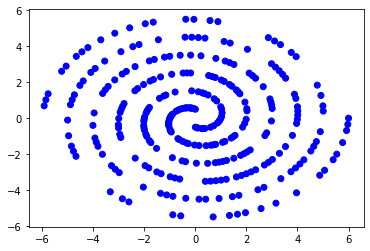

In [7]:
import time
time_begin = time.time()
train_spiral(net, data_train_iter, loss, updater, epoch_num, lr, batch_size)
time_end = time.time()
evaluate_spiral(net, data_test_iter, u1, v1, b1, u2, v2, b2)

print('the training time is:', time_end - time_begin)
#print(u1, v1, b1, u2, v2, b2)

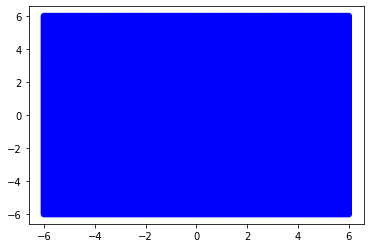

In [8]:
def create_points(low, high, num):
    result = []
    for x in np.linspace(low, high, num):
        for y in np.linspace(low, high, num):
            result.append([x, y])
    return np.array(result)

space = torch.from_numpy(create_points(-6, 6, 121)).float()

def decision_boundary(net, x):
    with torch.no_grad():
        y_hat = net(x, u1, v1, b1, u2, v2, b2)
        plot_decision_boundary(x, y_hat)
        
decision_boundary(net, space)